# Numerical simulation of the wave equation in 1D using Finite Difference

## Import libraries

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import sys

----

## Create domain model properties (i.e. speed of waves), and discretisation grid

In [3]:
nx = 800  # 800 gridpoints along the x-axis

# start with homogeneous model - same wave-speed everywhere.
c = np.full(nx,1500.0)  # Note: 1500m/s is typical acoustic velocity of water

# a faster section, halfway across model, to show reflection of waves when crossing sharp interface
#c[400:] = 2500.0  # Note: 2500m/s is fairly typical acoustic velocity of sedimentary rock

In [4]:
length = 6000.0  # assign a length to the model in metres

dx = length/nx  # calculate the spatial increment between model parameters

print('Domain is %d grid-cells (%.1fm)' % (nx,length))
print('Grid-spacing (dx) is %.5fm' % (dx))

Domain is 800 grid-cells (6000.0m)
Grid-spacing (dx) is 7.50000m


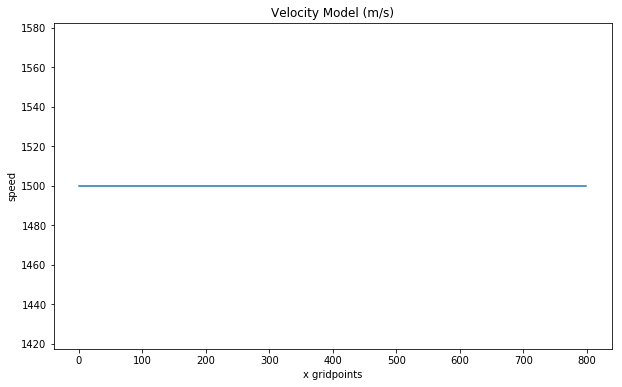

In [5]:
plt.figure(figsize=(10,6))
plt.plot(c) # plotting the velocity model
plt.xlabel('x gridpoints')
plt.ylabel('speed')
plt.title('Velocity Model (m/s)')
plt.show()

----
## Modelling constraints
#### CFL stability condition should be satisfied – the 'Courant number'.

The dimensionless Courant number, $C$, gives a measure of how far a signal will travel across a grid-cell (/between grid-points) within one time-step.
(Hence why I will very often refer to it as 'the crossing factor'.)

The crossing factor is $c$.$\delta t$/$\delta x$ for speed $c$, and we want the maximum value of this within the whole domain to satisfy some constraint that depends upon the finite-difference stencil(s) in use when modelling.

i.e. we want:$\quad \text{max}(c)$.$\delta t/\delta x <= C_{max}$, where $\ C_{max}$ depends on the discretisation.

We can turn this around to find the maximum time-step for our model and grid-spacing, given $C_{max}$ for our discretisation:

$$\delta t_{best} = \frac{C_{max}\ \delta x}{\text{max}(c)}$$

#### This simple stencil (2nd order), with 2nd order time-stepping, for the 1d wave equation, allows max crossing factor to be up to 1.0
(i.e. can only cross up to 100% of a cell in one time-step – but we'll use 80% below.)

In [6]:
C = 0.8  # set the dimensionless max Courant number that we want to use to work out time-step below

In [7]:
time = 5.0  # desired length of the simulation in seconds
dt = (C*dx)/c.max()  # define the best time-step by using the max Courant number
nt = int(time/dt+0.9999)  # find how many steps are needed to cover that time
time = nt*dt  # turn that back into exact time for this number of steps
print('Time-step = %.5fs  Number of steps = %d  (Total time being modelled: %.5fs)' % (dt,nt,dt*nt))

Time-step = 0.00400s  Number of steps = 1250  (Total time being modelled: 5.00000s)


### Create source function based on sine-squared curve...

In [8]:
# want to locate the source at some point in the grid, and give it an amplitude
sx = 150  # this is somewhat towards the left side (domain has 800 gridpoints)
amp = 1.0  # amplitude of the source function 

In [138]:
ns = 40  # make our source function have 40 steps
src = np.zeros(ns)  # create array for source function

# create source function with sine-squared curve (which starts off zero, rises to one, then back to zero)

for i in range(ns):
    src[i] = amp*np.sin((0.5+i)*np.pi/ns)**2

print('Endpoint values are: %.6f %.6f' % (src[0],src[-1]))

Endpoint values are: 0.001541 0.001541


### Create source function based on Ricker wavelet with peak frequency of 6Hz

The Ricker wavelet used here is a function of time that's defined from the second derivate of a Gaussian function (which is $G(t)=\text{e}^{-a^2 t^2}$).

–It's also known as the Mexican hat wavelet, due to its shape when plotted as a function of two variables.

It can be written so it is symmetric about time zero, with maximum at that time, ultimately decaying towards zero as $t$$\rightarrow$$±\infty$. However, we will shift it in time so that it starts near zero at our time zero.

After differentiating above Gaussian, $G(t)$, twice, flipping, then scaling (and before shifting in time), we get: $\quad R(t) = (1-2a^2 t^2)\ \text{e}^{-a^2 t^2}$

The peak frequency of the Ricker wavelet is at $f$=$a/\pi$.

The length of the wavelet, in time, before it decays close enough to zero for our purposes, is about $\frac{2.1}{f}$ (i.e. about $\frac{1.05}{f}$ seconds each side of the wavelet's central peak).

>**Task 1:**
>
>**Fill in code below to create a source function based on Ricker wavelet (see equations above)**

In [139]:
# NOTE: uncomment 8 lines of code below to prepare things for the code you fill in...

#freq = 6.0  # want Ricker wavelet to have peak frequency of 6Hz
#ts = 2.1/freq  # the length in time is related to frequency
#ns = int(ts/dt+0.9999)  # figure out how many time-steps are needed to cover that time
#src = np.zeros(ns)  # create array with new length, for wavelet
#print('Length of source is %d steps (%.5f secs, was %.5fs)' % (ns,ns*dt,ts))
#ts = ns*dt  # and now turn that back into a time that's exactly the required number of steps
#a2 = (freq*np.pi)**2  # a squared (see equation above)
#t0 = ts/2 - dt/2  # midpoint time of wavelet


# FILL IN CODE HERE TO CREATE SOURCE FUNCTION USING RICKER WAVELET (see equation above)...
# Its mid-point should be at time t0, which comes from code you uncommented above




print('Endpoint values are: %.6f %.6f' % (src[0],src[-1]))

Endpoint values are: 0.001541 0.001541


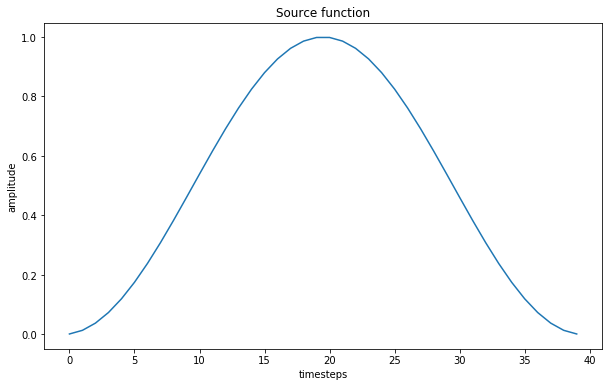

In [140]:
plt.figure(figsize=(10,6))
plt.plot(src) # plot source function
plt.xlabel('timesteps')
plt.ylabel('amplitude')
plt.title('Source function')
plt.show()

### Check that the maximum frequency in the source function can propagate reliably

For a simple second-order finite-difference, the minimum wavelength of a signal that we can propagate reliably is about 10 cells.

In [141]:
# minimum of 10 cells per wavelength for reasonably accurate propagation (i.e. minimal numerical dispersion):
min_cells_per_wl = 10.0

# calculate the max frequency that can be modelled without numerical dispersion:
max_freq = c.min()/(min_cells_per_wl*dx)

print('Maximum reliable propagation frequency is about %.1fHz' % max_freq)

Maximum reliable propagation frequency is about 20.0Hz


#### Want to avoid causing too much dispersion by keeping maximum significant frequency within this limit...

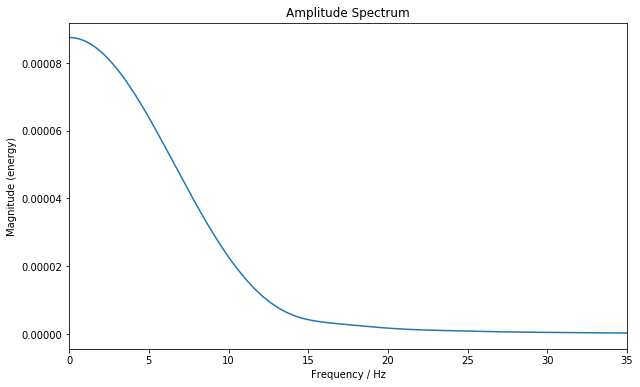

In [142]:
# plot amplitude spectrum of source function
plt.figure(figsize=(10,6))
plt.magnitude_spectrum(np.append(src,np.zeros(nt-ns)), Fs=1/dt)  # note padding to nt points
plt.title('Amplitude Spectrum')
plt.xlim(0,35)
plt.xlabel('Frequency / Hz')
plt.show()

## Receiver points within domain
–To detect what crosses a few particular points of the domain over time

>**Task 2:**
>
>**Create an array named `rpos` which will contain the positions of the detector points.**
>
>**Place detectors at three gridpoint positions: 70, 100 & 640 cells.**
>
>**Create a 2d array named `r` which will be used to record the wavefield at each detector and each time-step.**  
(The first dimension should be the same as number of detector points, second should be number of time-steps.)
>
>**Go to the time-stepping loop and fill in code to place the values of the current wavefield into the appropriate elements of the detector array `r` (based on the gridpoint positions given in array `rpos`)**
>
>**Once ready, go to the code cell below title "Plot data at receivers (detector points)" and uncomment the code in there.**  
–You can then see time plots of the data received at the three detector points.

In [154]:
# FILL IN CODE HERE TO INITIALISE ARRAYS rz & r...




----
# Simulation

In [144]:
# Initialise arrays for wavefields
u = np.zeros(nx) # current wavefield
u_prv = np.zeros(nx) # previous wavefield, at t-1
u_nxt = np.zeros(nx) # next wavefield, at t+1

In [145]:
# prepare an array to store wavefield snapshots for plotting
sampling_rate = 5 # set sampling rate used to store wavefield (every 10 timesteps)
wavefield = np.zeros((int(nt/sampling_rate), nx)) # array to store wavefields every 10 timesteps
print('Storing %d wavefields (every %dth out of %d)' % (wavefield.shape[0],sampling_rate,nt))

Storing 250 wavefields (every 5th out of 1250)


In [146]:
# a useful variable – shorthand for terms that appear together in equations
dtdx2 = (dt*dt)/(dx*dx)

In [147]:
u[sx] = src[0]  # put first source entry into current wavefield

# begin time-stepping loop...

for i in range(nt):

    if i%20==0:  # show progress every 20 steps
        sys.stdout.write('Done step %d of %d\r' % (i+1,nt))

    # find new wavefield, u_new, throughout domain (apart from edges)
    # NOTE: no vectorisation, so it's slow!
    for ix in range(1,nx-1):
        u_nxt[ix] = (c[ix]**2) * dtdx2 * (u[ix-1]-2*u[ix]+u[ix+1]) + 2*u[ix] - u_prv[ix]

    # put in source function as if it's a 'forced' boundary condition (rather than injecting by adding),
    # up until the source function runs out of steps
    if i+1<ns:
        u_nxt[sx] = src[i+1]
    
    
    # FILL IN CODE HERE TO RECORD VALUES AT DETECTOR POINTS, using arrays rpos & r...
    
    
    
    
    
    # shift wavefields for next time-step
    u_prv[:] = u[:]
    u[:] = u_nxt[:]
    
    # store the current wavefield u on every Nth step (where N=sampling_rate, as defined earlier)
    if (i+1)%sampling_rate == 0:
        wavefield[int((i+1)/sampling_rate-1),:] = u[:]

print('Finished all %d steps' % (nt))

Finished all 1250 steps


## Plot wavefield at different times

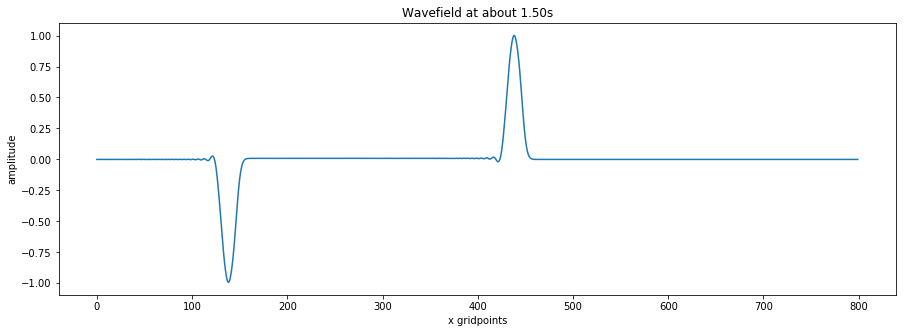

In [148]:
plot_time = 1.5  # 1.5 seconds
plt.figure(figsize=(15,5))
plt.plot(wavefield[int(plot_time/(dt*sampling_rate)),:])
plt.title('Wavefield at about %.2fs' % (plot_time))
plt.xlabel('x gridpoints')
plt.ylabel('amplitude')
plt.show()

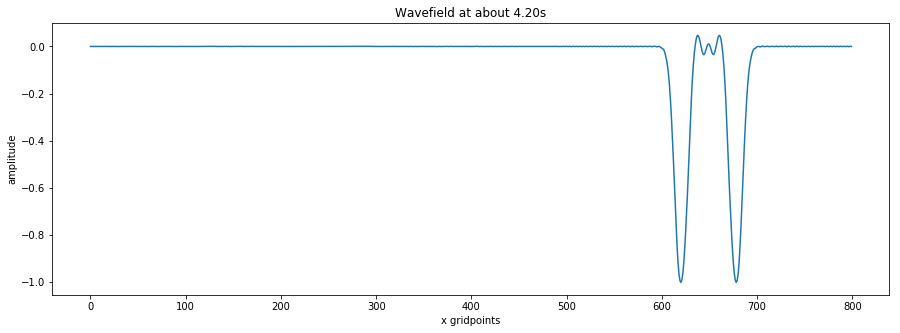

In [149]:
plot_time = 4.2  # 4.2 seconds
plt.figure(figsize=(15,5))
plt.plot(wavefield[int(plot_time/(dt*sampling_rate)),:])
plt.title('Wavefield at about %.2fs' % (plot_time))
plt.xlabel('x gridpoints')
plt.ylabel('amplitude')
plt.show()

## Plot data at receivers (detector points)

In [156]:
# UNCOMMENT THIS ONCE YOU HAVE BUILT ARRAYS r & rpos...

#for i in range(r.shape[0]):
#    plt.figure(figsize=(15,5))
#    plt.plot(r[i])
#    plt.title('Data for receiver at grid-point %d' % (rpos[i]))
#    plt.ylabel('Amplitude')
#    plt.xlabel('Time-steps')
#    plt.show()

## Show space-time plot for whole wavefield

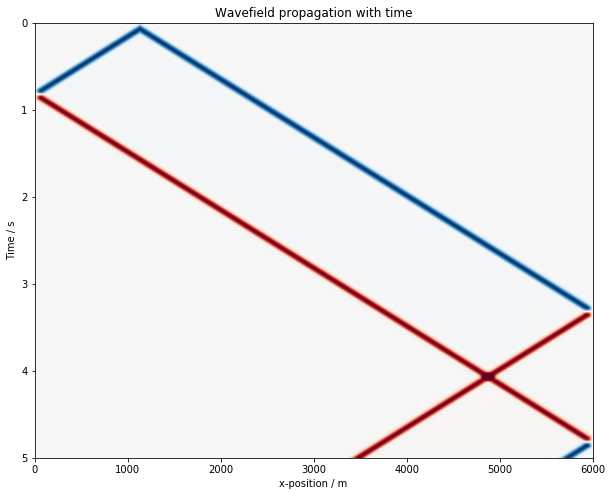

In [151]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wavefield, cmap='RdBu', interpolation='bilinear', aspect='auto',
           vmin=-1, vmax=1,       # set the bounds for the colour data
           extent=(0,length,time,0))  # set the bounds for the axes
plt.title('Wavefield propagation with time')
plt.xlabel('x-position / m')
plt.ylabel('Time / s')
plt.show()


## Make a movie! 

In [152]:
#plt.ioff()

fig, ax = plt.subplots(figsize=(15,6))

x = np.arange(0, wavefield.shape[1], 1)
line, = ax.plot(x,wavefield[0])

plt.title('Wavefield')
plt.xlabel('x gridpoint')
plt.ylabel('amplitude')
plt.ylim(-1.3,1.3)

#def init():  # only required for blitting to give a clean slate.
#    line.set_ydata(wavefield[0])
#    return line,

def frame(i):
    line.set_ydata(wavefield[i])
    return line,

print('Finished plots for frames, building animation...')

#ani = anim.FuncAnimation(fig, frame, init_func=init, interval=50, blit=True, save_count=wavefield.shape[0])
ani = anim.FuncAnimation(fig, frame, interval=50, save_count=wavefield.shape[0])

plt.close(fig)  # prevent final image from showing up inline just below

print('Preparing HTML (takes a little while...)')

HTML(ani.to_jshtml())

Finished plots for frames, building animation...
Preparing HTML (takes a little while...)
